# Pengenalan Angka Pada Aksara Sunda Menggunakan Convolutional Neural Network (CNN)

Notebook ini merupakan demo dari proses pembangunan model untuk megenali angka pada aksara sunda menggunakan convolutional neural network.
##### Hidayaturrahman (140810140050) - Universitas Padjadjaran

## Preprocessing Data

Mengubah data gambar ke dalam betuk biner. Kemudian dilakukan inversi pada nilainya sehingga menyederhanakan proses perhitungan. Data yang terlah diubah kemudia disimpan menjadi sebuah dataset.

In [2]:
%matplotlib inline

from PIL import Image
import PIL.ImageOps as ImOps
import numpy as np
import matplotlib.pyplot as plt

X = []
y = []

for i in range(1,16):
	for j in range(1,81):
		if j < 10:
			filename = "../gambar/resized/kertas-%d_0%d.jpg" % (i,j)
		else:
			filename = "../gambar/resized/kertas-%d_%d.jpg" % (i,j)
		img = Image.open(filename)
		inverted_image = ImOps.invert(img)
		matrix = np.array(inverted_image.convert('L'))
		label = j % 10
		if label == 0:
			label = 10
		label = label - 1

		X.append(matrix)
		y.append(label)


data = np.array(X)
label = np.array(y)

np.savez('aksara_sunda_ip.npz', data=data, label=label)


## Menampilkan data yang telah diolah

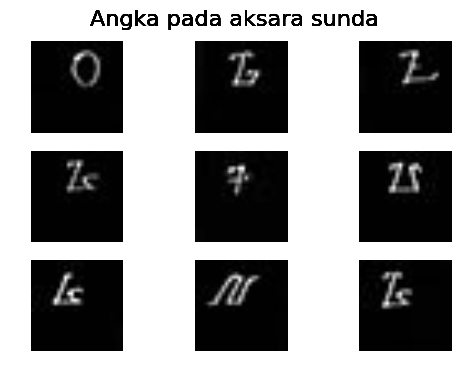

In [36]:
for i in range(9):
    plt.subplot(330+i)
    plt.imshow(X[i+9], cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.suptitle("Angka pada aksara sunda", size=16)
plt.show()

## Membangun Model Pertama
Model dibangun dengan mengunnakan Convolutional Neural Network.

In [ ]:
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline


# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

#load data
dataset = numpy.load('aksara_sunda.npz')
X = dataset['data']
y = dataset['label']

#reshape to be [samples][width][height][chanels]

X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')

# X = X[0:10]
# y = y[0:10]

#normalize the data
X = X / 255

# one hot encode output
y = np_utils.to_categorical(y)
num_classes = y.shape[1]

def baseline_model(optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Convolution2D(32, (6, 6), input_shape=(28, 28, 1), activation= 'relu' ))
	model.add(MaxPooling2D(pool_size=(2,2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model



## Melakukan Training Model Pertama
Training dilakukan dalam 10 epoch. Training dilakukan dengan menggunakan beberapa optimizer yakni ADAM, RMSProp, SGD, Adagrad, Adadelta, Adamax, dan Nadam.

In [ ]:
#### multiple optimizer
optimizer = ['adam','rmsprop','sgd','adagrad','adadelta','adamax','nadam']
model_acc = []
model_loss = []
for op in optimizer:
	model = baseline_model(op)
	history = model.fit(X, y, nb_epoch=10, batch_size=1, verbose=1)
	model_acc.append(history.history['acc'])
	model_loss.append(history.history['loss'])

numpy.savez('result_optimizer.npz', model_acc=model_acc, model_loss=model_loss, optimizer=optimizer)


## Menyimpan Model Pertama
Model disimpan dalam bentuk JSON dan bobot untuk setiap node disimpan dalam file HDF5

In [ ]:
#serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
	json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

## Visualisasi Proses Training Model Pertama
Visualisasi dilakukan untuk mengambarkan nilai akurasi dan loss model pada setiap iterasi

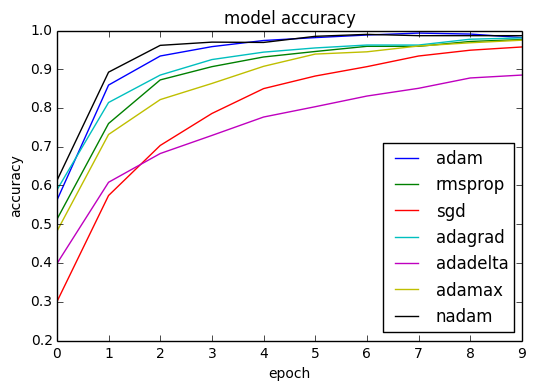

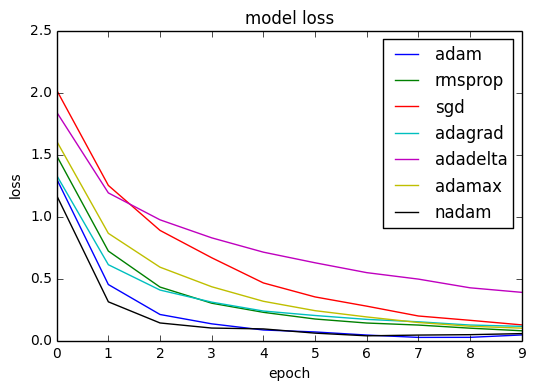

In [31]:
import numpy
import matplotlib.pyplot as plt

data = numpy.load('result_optimizer.npz')
model_acc = data['model_acc']
model_loss = data['model_loss']
optimizer = data['optimizer']

plt.figure(1)
for op in range(len(optimizer)):
	plt.plot(model_acc[op])
plt.title( 'model accuracy' )
plt.ylabel( 'accuracy' )
plt.xlabel( 'epoch' )
plt.legend(optimizer, loc= 'best' )

plt.figure(2)
for op in range(len(optimizer)):
	plt.plot(model_loss[op])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend(optimizer, loc= 'best' )
plt.show()

## Melakukan Evaluasi Model Pertama
Model dievaluasi dengan melakukan k-cross-validation

In [ ]:
############ k-fold validation
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=10, batch_size=1, verbose=1)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seedt)
result = cross_val_score(estimator, X, y, cv=kfold)
# numpy.savez('result_kfold.npz', result=result)
# print(result)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

## Membangun Model Kedua
Model dibangun dengan mengunnakan Convolutional Neural Network.

In [ ]:
def baseline_model_2(optimizer='adam'):
	# create model
	model = Sequential()
	model.add(Convolution2D(32, (6, 6), input_shape=(28, 28, 1), activation= 'relu' ))
	model.add(MaxPooling2D(pool_size=(2,2)))
	model.add(Dropout(0.4))
	model.add(Convolution2D(16, (6, 6), activation= 'relu' ))
	model.add(MaxPooling2D(pool_size=(2,2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(64, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

## Melakukan Training Model Kedua
Training dilakukan dalam 10 epoch. Training dilakukan dengan menggunakan beberapa optimizer yakni ADAM, RMSProp, SGD, Adagrad, Adadelta, Adamax, dan Nadam.

In [ ]:
#### multiple optimizer
optimizer = ['adam','rmsprop','sgd','adagrad','adadelta','adamax','nadam']
model_acc = []
model_loss = []
for op in optimizer:
	model = baseline_model_2(op)
	history = model.fit(X, y, nb_epoch=10, batch_size=1, verbose=1)
	model_acc.append(history.history['acc'])
	model_loss.append(history.history['loss'])

numpy.savez('result_optimizer_2.npz', model_acc=model_acc, model_loss=model_loss, optimizer=optimizer)

## Menyimpan Model Kedua
Model disimpan dalam bentuk JSON dan bobot untuk setiap node disimpan dalam file HDF5.

In [ ]:
#serialize model to JSON
model_json = model.to_json()
with open("model_2.json", "w") as json_file:
	json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_2.h5")
print("Saved model_2 to disk")

## Visualisasi Proses Training Model Kedua
Visualisasi dilakukan untuk mengambarkan nilai akurasi dan loss model pada setiap iterasi.

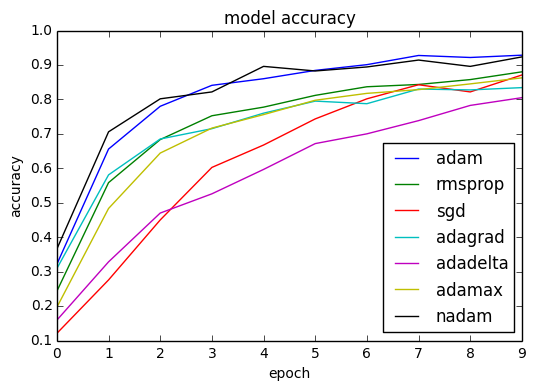

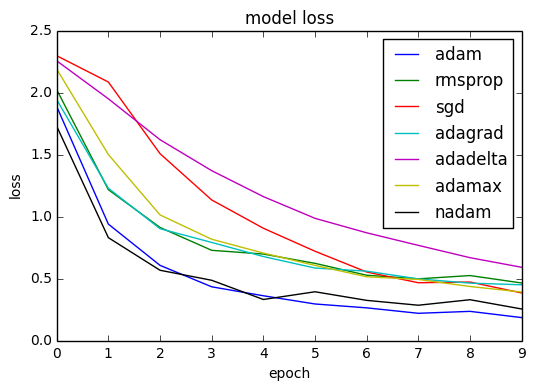

In [37]:
import numpy
import matplotlib.pyplot as plt

data = numpy.load('result_optimizer2.npz')
model_acc = data['model_acc']
model_loss = data['model_loss']
optimizer = data['optimizer']

plt.figure(1)
for op in range(len(optimizer)):
	plt.plot(model_acc[op])
plt.title( 'model accuracy' )
plt.ylabel( 'accuracy' )
plt.xlabel( 'epoch' )
plt.legend(optimizer, loc= 'best' )

plt.figure(2)
for op in range(len(optimizer)):
	plt.plot(model_loss[op])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend(optimizer, loc= 'best' )
plt.show()

## Melakukan Evaluasi Model Kedua
Model dievaluasi dengan melakukan k-cross-validation

In [ ]:
############ k-fold validation
estimator = KerasClassifier(build_fn=baseline_model_2, nb_epoch=10, batch_size=1, verbose=1)
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seedt)
result = cross_val_score(estimator, X, y, cv=kfold)
# numpy.savez('result_kfold.npz', result=result)
# print(result)
print("Accuracy: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))